In [63]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [64]:
data_dir = '/kaggle/input/asldataset/train'
batch_size = 32
img_size = (224, 224)

train_ds = keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=img_size,
  batch_size=batch_size)

val_ds = keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=img_size,
  batch_size=batch_size)

test_dir = '/kaggle/input/asldataset/test'

test_ds = keras.utils.image_dataset_from_directory(
  test_dir,
  image_size=img_size,
  batch_size=260)

Found 1300 files belonging to 26 classes.
Using 1040 files for training.
Found 1300 files belonging to 26 classes.
Using 260 files for validation.
Found 260 files belonging to 26 classes.


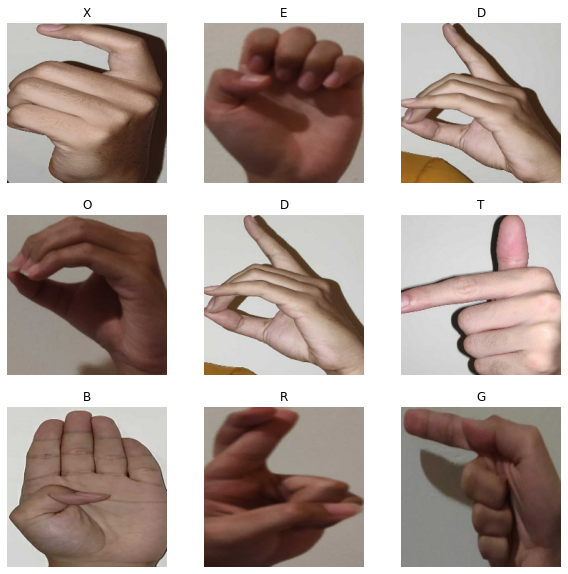

In [65]:
class_names = train_ds.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [66]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(val_ds))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_ds))

Number of validation batches: 9
Number of test batches: 1


In [67]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [68]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal"),
    layers.RandomZoom(0.1),
  ]
)

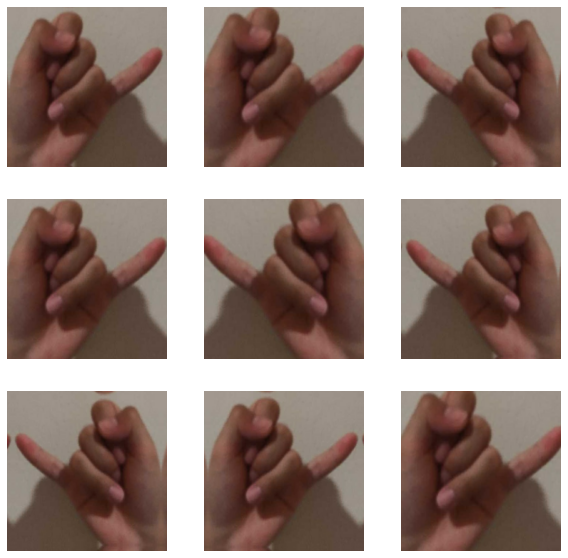

In [69]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [70]:
preprocess_input = keras.applications.resnet50.preprocess_input

In [71]:
IMG_SHAPE = img_size + (3,)
base_model = keras.applications.ResNet50(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [72]:
base_model.trainable = False

In [73]:
inputs = keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = layers.AveragePooling2D(pool_size=(7, 7))(x)
x = layers.Flatten(name="flatten")(x)
x = layers.Dense(256, activation="relu")(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(len(class_names))(x)

model = keras.Model(inputs, outputs)

In [74]:
model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-4),
              loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [75]:
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
sequential_2 (Sequential)    (None, 224, 224, 3)       0         
_________________________________________________________________
tf.__operators__.getitem_2 ( (None, 224, 224, 3)       0         
_________________________________________________________________
tf.nn.bias_add_2 (TFOpLambda (None, 224, 224, 3)       0         
_________________________________________________________________
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
average_pooling2d_2 (Average (None, 1, 1, 2048)        0         
_________________________________________________________________
flatten (Flatten)            (None, 2048)              0   

In [76]:
len(model.trainable_variables)

4

In [77]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(val_ds)

9/9 [==============================] - 3s 85ms/step - loss: 3.9019 - accuracy: 0.0538


In [78]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}%".format(accuracy0*100))

initial loss: 3.90
initial accuracy: 5.38%


In [79]:
history = model.fit(train_ds,
                    epochs=initial_epochs,
                    validation_data=val_ds)

Epoch 1/10
33/33 [==============================] - 8s 125ms/step - loss: 3.6754 - accuracy: 0.0558 - val_loss: 3.0454 - val_accuracy: 0.0923
Epoch 2/10
33/33 [==============================] - 4s 127ms/step - loss: 3.0226 - accuracy: 0.1327 - val_loss: 2.6866 - val_accuracy: 0.3192
Epoch 3/10
33/33 [==============================] - 4s 125ms/step - loss: 2.6201 - accuracy: 0.2750 - val_loss: 2.3876 - val_accuracy: 0.4423
Epoch 4/10
33/33 [==============================] - 4s 125ms/step - loss: 2.3889 - accuracy: 0.3327 - val_loss: 2.1064 - val_accuracy: 0.5808
Epoch 5/10
33/33 [==============================] - 4s 125ms/step - loss: 2.0906 - accuracy: 0.4212 - val_loss: 1.8599 - val_accuracy: 0.6538
Epoch 6/10
33/33 [==============================] - 4s 126ms/step - loss: 1.8950 - accuracy: 0.4885 - val_loss: 1.6202 - val_accuracy: 0.7615
Epoch 7/10
33/33 [==============================] - 4s 126ms/step - loss: 1.7168 - accuracy: 0.5500 - val_loss: 1.4591 - val_accuracy: 0.7692
Epoch 

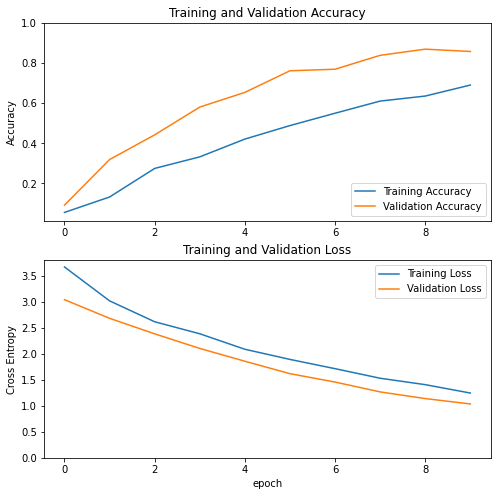

In [80]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,max(plt.ylim())])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [81]:
loss, accuracy = model.evaluate(test_ds)
print('Test accuracy :', accuracy)

1/1 [==============================] - 6s 6s/step - loss: 1.3754 - accuracy: 0.6731
Test accuracy : 0.6730769276618958


In [82]:
base_model.trainable = True

In [83]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 145

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False
    
fine_tune_epochs = 15
total_epochs =  initial_epochs + fine_tune_epochs

Number of layers in the base model:  175


In [84]:
model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-5),
              loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [85]:
len(model.trainable_variables)

40

In [86]:
history_fine = model.fit(train_ds,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=val_ds)

Epoch 10/25
33/33 [==============================] - 9s 182ms/step - loss: 0.9718 - accuracy: 0.7250 - val_loss: 0.5294 - val_accuracy: 0.9115
Epoch 11/25
33/33 [==============================] - 5s 158ms/step - loss: 0.6423 - accuracy: 0.8029 - val_loss: 0.3293 - val_accuracy: 0.9577
Epoch 12/25
33/33 [==============================] - 5s 155ms/step - loss: 0.4681 - accuracy: 0.8663 - val_loss: 0.2122 - val_accuracy: 0.9731
Epoch 13/25
33/33 [==============================] - 5s 156ms/step - loss: 0.3245 - accuracy: 0.9077 - val_loss: 0.1389 - val_accuracy: 0.9808
Epoch 14/25
33/33 [==============================] - 5s 155ms/step - loss: 0.2736 - accuracy: 0.9163 - val_loss: 0.0888 - val_accuracy: 0.9923
Epoch 15/25
33/33 [==============================] - 5s 155ms/step - loss: 0.1992 - accuracy: 0.9394 - val_loss: 0.0609 - val_accuracy: 0.9962
Epoch 16/25
33/33 [==============================] - 5s 159ms/step - loss: 0.1443 - accuracy: 0.9587 - val_loss: 0.0430 - val_accuracy: 1.0000

In [87]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss = history.history['loss'] + history_fine.history['loss']
val_loss = history.history['val_loss'] + history_fine.history['val_loss']

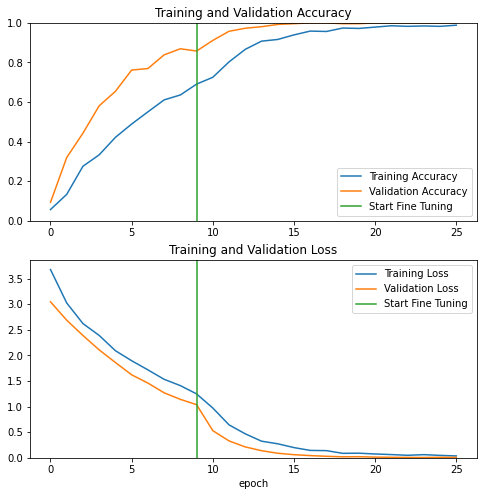

In [88]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, max(plt.ylim())])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [89]:
loss, accuracy = model.evaluate(test_ds)
print('Test accuracy :', accuracy)

1/1 [==============================] - 1s 760ms/step - loss: 0.3751 - accuracy: 0.8846
Test accuracy : 0.8846153616905212


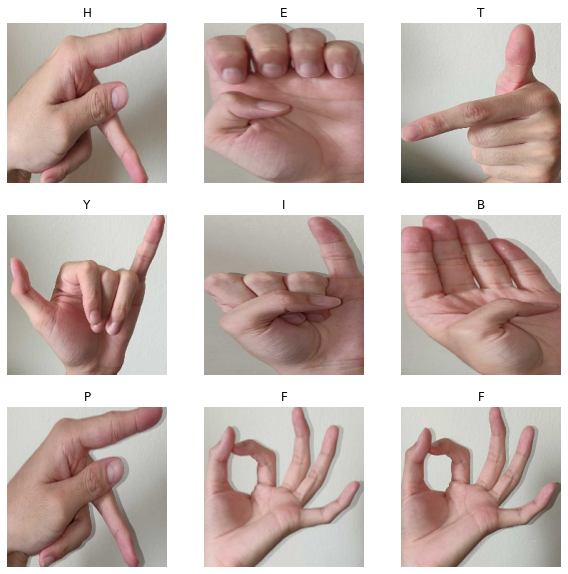

In [90]:
image_batch, label_batch = test_ds.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch)
predictions = tf.nn.softmax(predictions)

plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image_batch[i].astype("uint8"))
    plt.title(class_names[np.argmax(predictions[i])])
    plt.axis("off")

In [91]:
y_pred = np.argmax(predictions, axis=1)
print(y_pred)
print(label_batch)

[ 7  4 19 24  8  1 15  5  5  0  2  2 22  4 20  9  1  7 22 13 17 12 23 16
  7 22  3  7  9 11 12 23  7 23  8  0 24 12  9 14 12  5 14  1 23  6 23 25
 16 25 21 24  9  6 12 21 17 20 17 13  8 19 22 16  1 12 14  9 12  3  1 19
 10 10  6 14 23  2  5 23 12 22 16 16 10  2 10  3 25  0 25  7  6  5  2 21
  2 12  3  7 18 25 24 18  4  4  9 13 25  7  6 20  7 17  1 12 18  8  2 22
 11  5  7  0 11 24 24 22 24  7 22 13  3 23 14  1  1  7 24 12  7 14 18  5
 17 25  8  4 11 22 11  6 19  9 22  7 12  7 16 25 22 14  0 23 17 13 14  8
 10  1 11 18 19  8 20  8 21 24 22 12  5  1  4 13 12  5 13 19 12 19  2 19
  4 12  8  7 21 10 19 11 15 10 18 16 20 13  8 11  7  3  5  9 10 11 17  6
 19 10 17 16  7  6  7 22  9 12 20 13 14 14 10  4 22 21  9 13 22  3 16  6
 23 25  3 22 16 11  2  3  2 13 17 11 17 22 13 18 18  3 10 25]
[15  4 19 24  8  1 15  5  5  0  2  2 22  4 20  9  1  7 22 13 17  0 23 16
  7 22  3 15  9 11  0 23  7 23  8  0 24  0  9 14 12  5 14  1 23  6 23 25
 16 25 21 24  9  6 12 20 17 20 17 13  8 19 21 16  1 12 14  9 1

<AxesSubplot:>

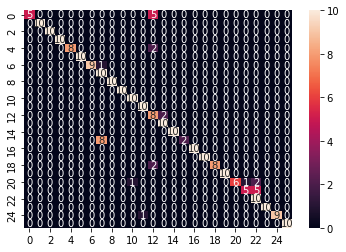

In [92]:
from tensorflow.math import confusion_matrix

conf_matrix = confusion_matrix(label_batch, y_pred)


import seaborn as sns
sns.heatmap(conf_matrix, annot=True)

In [93]:
model.save('modelResNet50.h5')

In [95]:
import os
os.chdir(r'/kaggle/working/')

In [96]:
from IPython.display import FileLink
FileLink(r'modelResNet50.h5')

/kaggle/working/modelResNet50.h5